In [1]:
import pandas as pd
import numpy as np

def create_df_response(samples, time,  quantiles = [50, 80, 95], forecast_horizon=27, date_init=None, sample_freq="D", dates=None, use_future=False):
    """ Create a dataframe with the quantiles of the model and forecast if provided

    Args:
        samples    : Samples of the variable to create the dataframe. It should be a 2D array with shape (n_time, n_samples)
        time (int) : n_time
        date_init (str, optional):        [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional):      [description]. Defaults to False.

    Returns:
        df_response: Dataframe with the quantiles of the model, mean, median and std.
    """

    if samples.shape[0] != time:
        raise Exception("Samples first dimension must be equal to time")

    if dates is not None:
        dates_fitted = dates
    elif date_init is not None and sample_freq is not None:
        dates_fitted = pd.date_range(pd.to_datetime(date_init), periods=time, freq=sample_freq)
    else:
        dates_fitted   = list(range(time))
        dates_forecast = list(range(time, time+forecast_horizon))

    dates = dates_fitted
    types = ['estimate']*len(dates_fitted)

    if use_future:
        dates += list(dates_forecast)
        types += ['forecast']*len(dates_forecast)

    results_df  = pd.DataFrame(samples)
    df_response = pd.DataFrame(index=dates)

    # Calculate key statistics
    df_response['mean']   = results_df.mean(axis=1).values
    df_response['median'] = results_df.median(axis=1).values
    df_response['std']    = results_df.std(axis=1).values

    for quant in quantiles:
        low_q                        = ((100-quant)/2)/100
        high_q                       = 1-low_q
        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']    =  types
    df_response.index.name = 'date'

    return df_response

def transition(var, rate, dt=1):
    kb        = np.maximum(1.0 - np.exp(-rate*dt), 0)
    num_ind   = np.random.binomial(list(var), kb )
    return num_ind


In [2]:
class Agent:
    S = 0
    I = 1
    R = 2

class gen:
    A: 0
    C: 1
    G: 2
    T: 3

def random_mutation(genome, model_settings, params_genetic):
    """ Random mutation over an arranged genome

    Args:
        genome (np.ndarray): numpy array with state of the genome. size is (number of people x length genome x number of ensembles)
        model_settings (dict): Dictionary with model settings.
        params_genetic (dict): Dictionary with genetic parameters.

    Returns:
        genome (np.ndarray): numpy array with state of the genome after random mutation.
                                    size is (number of people x length genome x number of ensembles)
    """
    n  = model_settings["n"]
    m  = model_settings["m"]

    lg = params_genetic["lg"]
    μ  = params_genetic["mu_r"]
    ng = params_genetic["ng"]

    mutate =  np.random.random(size=(n, lg, m)) <= μ
    genome =  (genome*(~mutate)) + np.random.randint(0, ng, size=(n, lg, m)) * mutate
    return genome

def f(agents_state, xm, genome, epi_params, evo_params, model_settings):
    """ Process model evolving epidemiological agent states, their genome and mosquito compartmental model.

    Args:
        agents_state (numpy.ndarray): array of size number of people x number of ensembles with agent states \in {0: S, 1 : I, 2: R}
        xm (numpy.ndarray): array with mosquito compartments of size [3 (susceptible, exposed, infected) x number of ensembles]
        epi_params (dict): Dictionary with epidemiological parameters.
        evo_params (dict): Dictionary with evolutionary parameters.
        model_settings (dict): Dictionary with model settings.

    Returns:
        p_update (numpy.ndarray): array with updated agent states of size (number of people x number of ensembles)
        new_infected (numpy.ndarray): array with number of new infected people of size [number of ensembles]
        xm (numpy.ndarray): array with updated mosquito compartments of size [3 (susceptible, exposed, infected) x number of ensembles]
        genome (numpy.ndarray): array with updated genome of size [number of people x length genome x number of ensembles]
    """

    n        = model_settings["n"] # number of patients
    m        = model_settings["m"] # number of ensembles
    p_update = agents_state.copy()

    beta     = epi_params["beta"]   # probability of infection given bite.
    gamma    = epi_params["gamma"]  # recovery rate.
    N        = epi_params["Nh"]     # human population size.
    r        = epi_params["r"]      # mosquito birth rate.
    muv      = epi_params["muv"]    # mosquito death rate.
    sigma    = epi_params["sigma"]  # mosquito infection rate.
    b        = epi_params["b_rate"] # bitting rate.
    Nm       = epi_params["Nm"]     # mosquito pop.
    kv       = epi_params["kv"]     # mosquito carrying capacity.

    sm     = xm[0, :]
    em     = xm[1, :]
    im     = xm[2, :]

    λhv    = beta * b * im / Nm # foi human to vector

    Pr       = np.random.random(size=(n, m)) <= gamma
    Pinf     = np.random.random(size=(n, m)) <= λhv

    p_update = p_update + Agent.R * ( (agents_state==Agent.I) * Pr)   # Infected to recovered
    p_update = p_update + Agent.I * ( (agents_state==Agent.S) * Pinf) # Susceptible to infected

    p_update     = np.clip(p_update, 0, 2)
    new_infected = np.sum(Agent.I * ( (agents_state==Agent.S) * Pinf), axis=0)

    # mosquito dynamics
    λvh = beta * b * np.sum(agents_state==Agent.I, axis=0) / N # foi vector to human

    Nm             = sm+em+im
    mosbirth       = transition(Nm, r)
    mos_competence = transition(Nm, r * (Nm/kv))

    sm2death  = transition(sm, muv )
    em2death  = transition(em, muv )
    im2death  = transition(im, muv )

    foi_m     = transition(sm, λvh)
    em2im     = transition(em, sigma)

    sm = sm - foi_m + mosbirth - mos_competence - sm2death
    em = em + foi_m - em2im                     - em2death
    im = im + em2im                             - im2death

    xm     = np.vstack((sm, em, im))
    genome = random_mutation(genome, model_settings, evo_params)

    return p_update, new_infected, np.clip(xm, 0, None), genome

def init_epi(model_settings, i0, im0, epidemiological_parameters):
    """ Initial conditions of the epidemiological model

    Args:
        model_settings (dict): dictionary with model settings
        i0 (float): Initial human infected fraction
        im0 (float): Initial mosquito infected fraction.
        epidemiological_parameters (dict): Dictionary with the epidemiological parameters.

    Returns:
        _type_: _description_
    """
    n, m = model_settings["n"], model_settings["m"]
    Nm           = epidemiological_parameters["Nm"]

    agents_state = np.zeros((n, m)) + Agent.I * (np.random.random(size=(n, m)) <= i0)

    sv0 = Nm*im0
    xm0 = np.array([[Nm-sv0], [0], [sv0]]) * np.ones((3, m))
    return agents_state, xm0

def init_evo(evolutionary_parameters, model_settings):
    """ Initial conditions of the human population genome

    Args:
        evolutionary_parameters (dictionary): _description_
        model_settings (dictionary): _description_

    Returns:
        np.array: matrix of size number of people x length genome x number of ensembles
    """

    ng = evolutionary_parameters["ng"]
    lg = evolutionary_parameters["lg"]

    n  = model_settings["n"]
    m  = model_settings["m"]

    return np.random.randint(0, ng, size=(n, lg, m))

def f0(model_settings, i0, im0, epidemiological_parameters, evolutionary_parameters):
    agents_state, xm0 = init_epi(model_settings, i0, im0, epidemiological_parameters)
    genome_state      = init_evo(evolutionary_parameters, model_settings)
    return agents_state, xm0, genome_state

def g(new_infected, ρ):
    return np.random.binomial(new_infected, ρ)

params_epi          = {}
params_epi["beta"]  = 0.3  # Infection probability from vector to human.
params_epi["gamma"] = 1/14 # Human infectious period. [days]

params_epi["r"]      = 1/7  # Mosquito birth rate.
params_epi["muv"]    = 1/14 # Mosquito death rate. [1/days]
params_epi["b_rate"] = 0.3  # Mosquito bitting rates.
params_epi["kv"]     = 2e4  # Mosquito carrying capacity.
params_epi["sigma"]  = 1/10 # Mosquito infectious period. [days]

params_epi["Nh"]     = 1e6   # Human population.
params_epi["Nm"]     = params_epi["kv"] * (1 - params_epi["muv"]/params_epi["r"]) # Mosquito population.

params_evo = { "lg"    : 10,  # length genome.
                "ng"   : 4,   # length genome dictionary.
                "mu_r" : 0.1  # mutation rate.
                }


In [3]:
n = 8000 # n agents
m = 500  # m samples/ensembles

model_settings = {"n": n,
                  "m": m}

T                        = 100
agents_state, xm, genome = f0(model_settings, i0=1/100, im0=30/100, epidemiological_parameters=params_epi, evolutionary_parameters=params_evo)


s = np.full((T, m), np.nan); s[0, :] = np.sum(agents_state==Agent.S, axis=0)
i = np.full((T, m), np.nan); i[0, :] = np.sum(agents_state==Agent.I, axis=0)
r = np.full((T, m), np.nan); r[0, :] = np.sum(agents_state==Agent.R, axis=0)
c = np.full((T, m), np.nan); c[0, :] = g(np.sum(agents_state==Agent.I, axis=0), ρ=0.5)

xm_all          = np.full((T, 3, m), np.nan)
xm_all[0, :, :] = xm

In [4]:
for t in range(1, T):
    agents_state, newI, xm_all[t, :, :], genome = f(agents_state, xm_all[t-1, :, :], genome,
                                            epi_params = params_epi,
                                            evo_params = params_evo,
                                            model_settings = model_settings)

    s[t, :] = np.sum(agents_state==Agent.S, axis=0)
    i[t, :] = np.sum(agents_state==Agent.I, axis=0)
    r[t, :] = np.sum(agents_state==Agent.R, axis=0)
    c[t, :] = g(newI, ρ=0.5)


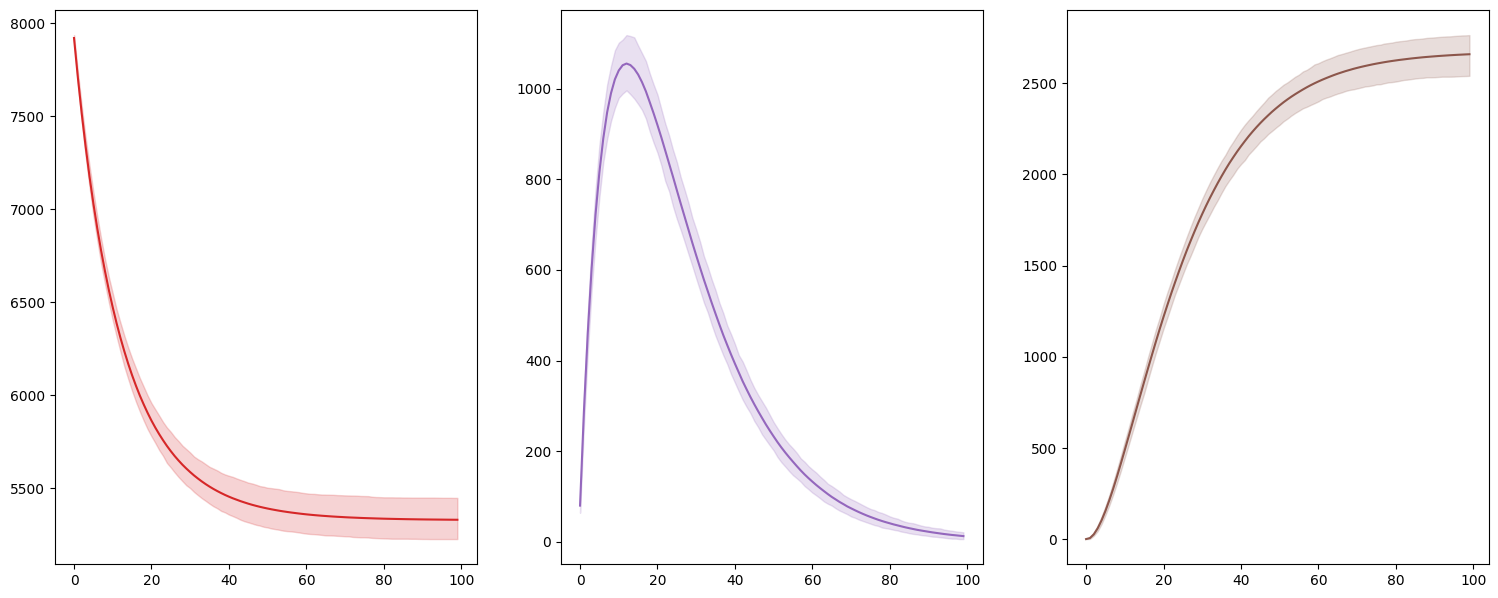

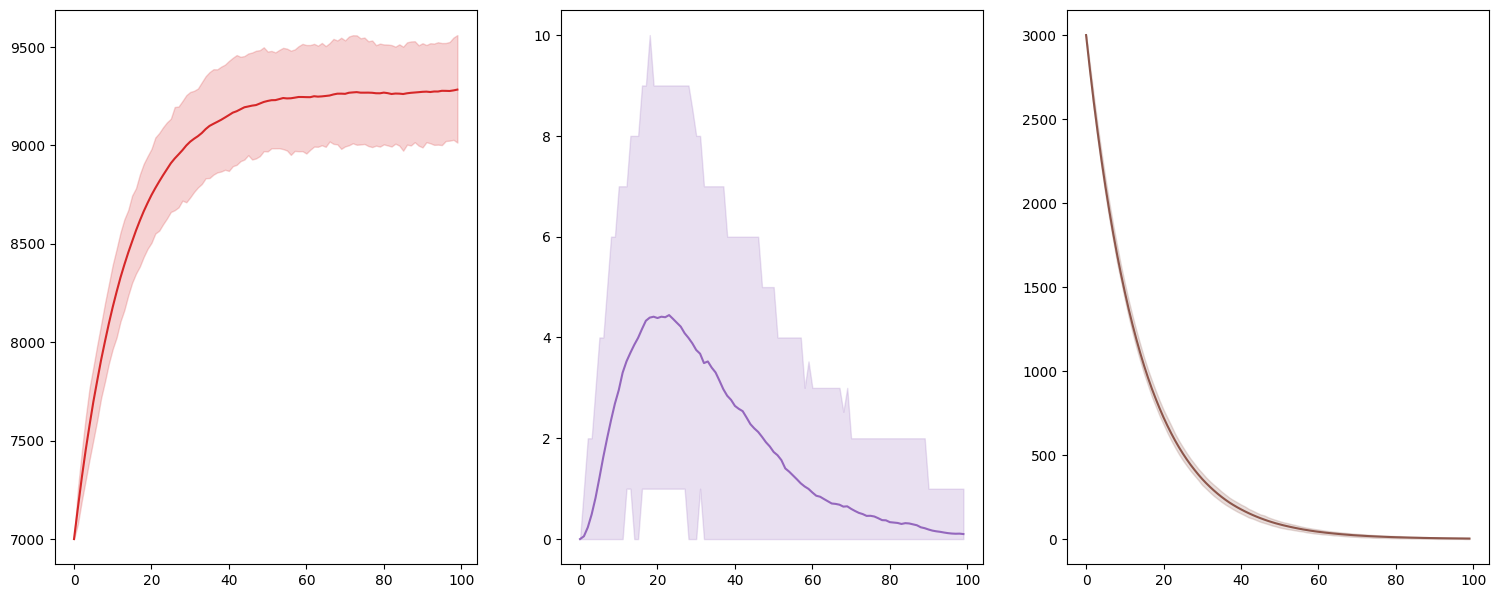

In [5]:
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from utils import create_df_response

colors  = ["#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

fig, ax = plt.subplots(1, 3, figsize=(18.5, 7.2), sharex=True, sharey=False)

S_df = create_df_response(s, time=T)
I_df = create_df_response(i, time=T)
R_df = create_df_response(r, time=T)
C_df = create_df_response(c, time=T)

ax[0].plot(range(T), S_df["mean"], label=r"$S$", color=colors[0])
ax[0].fill_between(range(T), S_df["low_95"], S_df["high_95"], alpha=0.2, color=colors[0])

ax[1].plot(range(T), I_df["mean"], label=r"$I$", color=colors[1])
ax[1].fill_between(range(T), I_df["low_95"], I_df["high_95"], alpha=0.2, color=colors[1])

ax[2].plot(range(T), R_df["mean"], label=r"$R$", color=colors[2])
ax[2].fill_between(range(T), R_df["low_95"], R_df["high_95"], alpha=0.2, color=colors[2])

######-######-######-######-######
sm_df = create_df_response(xm_all[:, 0, :], time=T)
em_df = create_df_response(xm_all[:, 1, :], time=T)
im_df = create_df_response(xm_all[:, 2, :], time=T)

fig, ax = plt.subplots(1, 3, figsize=(18.5, 7.2), sharex=False, sharey=False)

ax[0].plot(range(T), sm_df["mean"], label=r"$S_m$", color=colors[0])
ax[0].fill_between(range(T), sm_df["low_95"], sm_df["high_95"], alpha=0.2, color=colors[0])

ax[1].plot(range(T), em_df["mean"], label=r"$E_m$", color=colors[1])
ax[1].fill_between(range(T), em_df["low_95"], em_df["high_95"], alpha=0.2, color=colors[1])

ax[2].plot(range(T), im_df["mean"], label=r"$I_m$", color=colors[2])
ax[2].fill_between(range(T), im_df["low_95"], im_df["high_95"], alpha=0.2, color=colors[2])



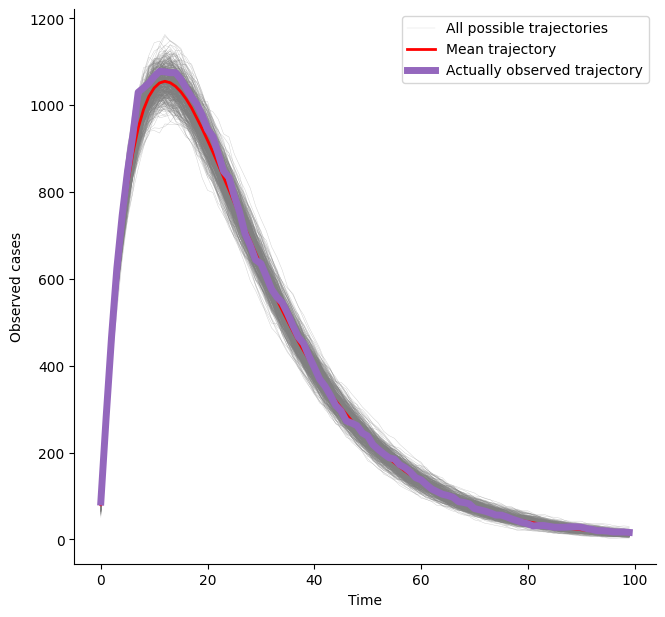

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.2), sharex=True, sharey=False)

ax.plot(range(T), i, color="gray", alpha=0.4, lw=0.3)
ax.plot(range(T), i[:, np.random.randint(500)], color="gray", label="All possible trajectories", alpha=0.3, lw=0.3)
ax.plot(range(T), np.mean(i, -1), color="red", label="Mean trajectory", lw=2)

ax.plot(range(T), i[:, np.random.randint(500)], label="Actually observed trajectory", color=colors[1], lw=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Observed cases")
ax.set_xlabel("Time")

ax.legend()